## Creating a Python virtual environment

This will enable the installation of non-standard Python packages for use within the Jupyter Notebook only. Code copied from [here](https://github.com/cedadev/ceda-notebooks/blob/master/notebooks/intro/notebook-tour-part-6.ipynb).

#### Step 1 – Create a venv
Note that these venvs will not work when logged into JASMIN directly via SSH.

In [1]:
import virtualenv
import pip
import os

# Define and create the base directory install virtual environments
venvs_dir = os.path.join(os.path.expanduser("~"), "nb-venvs")

if not os.path.isdir(venvs_dir):
    os.makedirs(venvs_dir)
    
# Define the venv directory
venv_dir = os.path.join(venvs_dir, 'venv-notebook')

# Since you only need to create the virtual environment once, check for its existence before trying to create it
if not os.path.isdir(venv_dir):
    # Create the virtual environment
    print(f'[INFO] Creating: virtual env at: {venv_dir}')
    virtualenv.create_environment(venv_dir)

#### Step 2 – Activate the venv

In [2]:
activate_file = os.path.join(venv_dir, "bin", "activate_this.py")
exec(open(activate_file).read(), dict(__file__=activate_file))

#### Step 3 – Install new packages

In [23]:
# pip install a package using the venv as a prefix
installs = ["xlrd", "openpyxl"]
for package in installs:
    pip.main(["install", "--prefix", venv_dir, package])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/opt/jaspy/bin/python -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached openpyxl-3.0.6-py2.py3-none-any.whl (242 kB)
Processing ./.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31/et_xmlfile-1.0.1-py3-none-any.whl
  Using cached jdcal-1.4.1-py2.py3-none-any.whl (9.5 kB)


You should consider upgrading via the '/opt/jaspy/bin/python -m pip install --upgrade pip' command.


## Code

In [3]:
# Imports

from os import path, makedirs, listdir
import requests
import pandas as pd
import zipfile as zpf
import matplotlib.pyplot as plt
import xlrd
from openpyxl import load_workbook

Define the HealthData class with various properties and functions.

In [18]:
# Data class definition

class HealthData():
    def __init__(self, home_folder, url=False, filename=False):
        self.home_folder = home_folder
        if url:
            self.url = url
            self.filename = path.basename(self.url)
        elif filename:
            self.filename = filename
        _, self.extension = path.splitext(self.filename)
        self.filepath = path.join(self.home_folder, self.filename)

        if not path.exists(self.home_folder):
            makedirs(self.home_folder)

    def download(self, verbose=True):
        request = requests.get(self.url)
        file = open(self.filepath, 'wb')
        file.write(request.content)
        file.close()
        if verbose:
            print(f"Saved to {self.filename}")
        if self.extension == ".zip":
            self.zipfiles = zpf.ZipFile(self.filepath).namelist()
            if verbose:
                print("Contains zip files:")
                [print(f"[{i}] {self.zipfiles[i]}") for i in range(len(self.zipfiles))]
        elif self.extension == ".xls":
            workbook = xlrd.open_workbook(self.filepath)
            self.sheets = workbook.sheet_names()
            if verbose:
                print(f"Contains xls sheets: {self.sheets}")
        elif self.extension == ".xlsx":
            workbook = load_workbook(self.filepath)
            self.sheets = workbook.sheetnames
            if verbose:
                print(f"Contains xlsx sheets: {self.sheets}")
                
    def unzip(self, file="all", verbose=True):
        with zpf.ZipFile(self.filepath, 'r') as zip_ref:
            if file =="all":                                       # Extract all zipped files.
                zip_ref.extractall(self.home_folder)
            else:                                                  # Extract one specified file,
                zip_ref.extract(file, self.home_folder)            # then
                self.filename = path.basename(file)                # reset the file name, path and extension info.
                _, self.extension = path.splitext(self.filename)
                self.filepath = path.join(self.home_folder, self.filename)
        if verbose:
            print(f"Unzipped {file}.")

    def read_csv(self, verbose=True):
        if verbose:
            print(f"Reading {self.filename}...")
        return pd.read_csv(self.filepath)
    
    def read_xls(self, sheet_name, verbose=True):
        if verbose:
            print(f"Reading {self.filename}...")
        if self.extension == ".xls":
            return pd.read_excel(self.filepath, sheet_name)
        elif self.extension == ".xlsx":
            workbook = load_workbook(self.filepath)
            worksheet = workbook[sheet_name]
            return pd.DataFrame(worksheet.values)

### Hospital admissions
Monthly resolution, England.

In [46]:
url_health = "https://files.digital.nhs.uk/5C/1F3B67/HES_M09_2021_OPEN_DATA.zip"
home_folder = path.join(path.abspath(""), "hosp_admissions_data")
health_data = HealthData(home_folder, url=url_health)

In [47]:
health_data.download(verbose=False)

In [48]:
file = health_data.zipfiles[1]
health_data.unzip(file=file, verbose=False)
df = health_data.read_csv(verbose=False)
#df.head(3)

In [49]:
cols_of_interest = ["CALENDAR_MONTH_END_DATE", "APC_Finished_Consultant", "APC_Emergency", "Outpatient_Total_Appointments"]
health_df = df[cols_of_interest]

In [50]:
health_df.set_index("CALENDAR_MONTH_END_DATE", inplace=True)
#health_df.head(3)

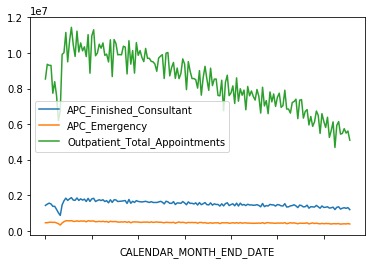

In [51]:
health_df.plot()
plt.show()

Figure: England-wide hospital admissions data.

### Mortality
Monthly data across England & Wales; by age, sex, region. Processed to look specifically at London region (all ages, all sexes).

In [159]:
home_folder = path.join(path.abspath(""), "mortality_data")

#### Download & process the mortality data

Perks of using Excel files from the Office for National Statistics...

In [160]:
urls = {2021:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2021/publishedweek07202101032021165557.xlsx",
       2020:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2020/publishedweek532020.xlsx",
       2019:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2019/publishedweek522019.xls",
       2018:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2018/publishedweek522018withupdatedrespiratoryrow.xls",
       2017:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2017/publishedweek522017.xls",
       2016:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2016/publishedweek522016.xls",
       2015:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2015/publishedweek2015.xls",
       2014:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2014/publishedweek2014.xls",
       2013:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2013/publishedweek2013.xls",
       2012:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2012/publishedweek2012.xls",
       2011:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2011/publishedweek2011.xls",
       2010:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2010/publishedweek2010.xls"
       }

sheet_names = {2021:f"Weekly figures 2021",
            2020:f"Weekly figures 2020",
            2019:f"Weekly figures 2019",
            2018:f"Weekly figures 2018",
            2017:f"Weekly figures 2017",
            2016:f"Weekly figures 2016",
            2015:f"Weekly Figures 2015",
            2014:f"Weekly Figures 2014",
            2013:f"Weekly Figures 2013",
            2012:f"Weekly Figures 2012",
            2011:f"Weekly Figures 2011",
            2010:f"Weekly Figures 2010"}

row_indices = {2021:[5, 88],
              2020:[5, 92],
              2019:[3, 47],
              2018:[3, 47],
              2017:[3, 47],
              2016:[3, 47],
              2015:[3, 47],
              2014:[2, 47],
              2013:[3, 47],
              2012:[3, 47],
              2011:[3, 48],
              2010:[3, 47]}

In [161]:
mortality_df = pd.DataFrame()

for year in range(2010, 2022):
    mortality_annual = HealthData(home_folder, url=urls[year])
    mortality_annual.download(verbose=False)
    df = mortality_annual.read_xls(sheet_names[year], verbose=False)
    rows = row_indices[year]
    annual_df = df.loc[rows]
    annual_df = annual_df.T.dropna().rename(columns={rows[0]:"date", rows[1]:"weekly_deaths"}).reset_index(drop=True).drop([0]).set_index("date")
    annual_df.index = pd.to_datetime(annual_df.index)
    if mortality_df.empty:
        mortality_df = annual_df.copy()
    else:
        mortality_df = mortality_df.append(annual_df.copy())
    print(f"{year} done...")
    
mortality_df.to_csv(path.join(home_folder, "weekly_mortality_London.csv"))

2010 done...
2011 done...
2012 done...
2013 done...
2014 done...
2015 done...
2016 done...
2017 done...
2018 done...
2019 done...
2020 done...
2021 done...


#### Load the processed data from .csv file

In [162]:
mortality_annual = HealthData(home_folder, filename="weekly_mortality_London.csv")
mortality_df = mortality_annual.read_csv().set_index("date")
mortality_df.index = pd.to_datetime(mortality_df.index)
mortality_df.head()

Reading weekly_mortality_London.csv...


,weekly_deaths
date,
2010-01-08,1226
2010-01-15,1262
2010-01-22,1186
2010-01-29,1093
2010-02-05,1035


#### Plot the dataframe

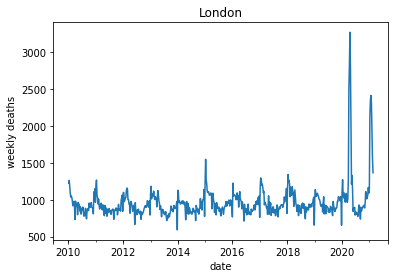

In [163]:
mortality_df.plot(legend=False, title="London").set_ylabel("weekly deaths")
plt.show()

### Population data

In [164]:
home_folder = path.join(path.abspath(""), "population_data")

#### Download & process the population data

In [165]:
url = "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2001tomid2019detailedtimeseries/regionalpopestimatesforenglandandwales19712019.xlsx"
pop_data = HealthData(home_folder, url=url)
pop_data.download()

Saved to regionalpopestimatesforenglandandwales19712019.xlsx
Contains xlsx sheets: ['Contents', 'Terms and conditions', 'Notes and definitions', 'Table 1', 'Table 2', 'Table 3', 'Table 4', 'Related publications']


In [166]:
population_df = pd.DataFrame()

for sheet in ["Table 3", "Table 4"]:
    df = pop_data.read_xls(sheet, verbose=False)
    df = df.loc[df[0].apply(lambda x: isinstance(x, int))].reset_index(drop=True)[[0]].rename(columns={0:"date"}).join(df.loc[df[1]=="London"].reset_index(drop=True)[[2]].rename(columns={2:"total_population"})).set_index("date")
    df.index = pd.to_datetime(df.index, format="%Y") + pd.tseries.offsets.DateOffset(months=6) # Set these as mid-year estimates
    if population_df.empty:
        population_df = df.copy()
    else:
        population_df = population_df.append(df.copy())
        
population_df.to_csv(path.join(home_folder, "annual_population_London.csv"))

#### Load the processed data from .csv file

In [167]:
pop_data = HealthData(home_folder, filename="annual_population_London.csv")
population_df = pop_data.read_csv().set_index("date")
population_df.index = pd.to_datetime(population_df.index)
population_df.head(3)

Reading annual_population_London.csv...


,total_population
date,
1981-07-01,6805000
1982-07-01,6765084
1983-07-01,6752989


#### Plot the dataframe

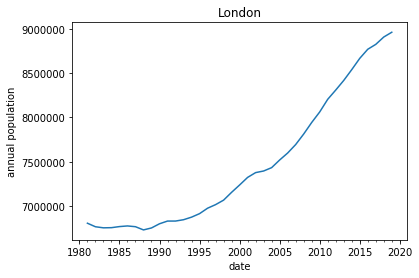

In [168]:
population_df.plot(legend=False, title="London").set_ylabel("annual population")
plt.show()

#### Interpolation of annual data

In [152]:
step_df = population_df.resample("D").asfreq().fillna(method="ffill")
linear_df = population_df.resample("D").asfreq().interpolate(method="linear")

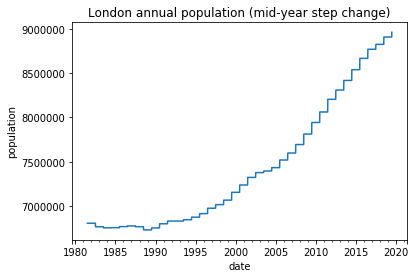

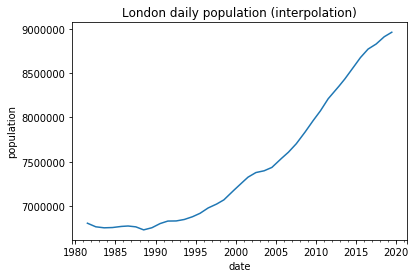

In [156]:
step_df.plot(legend=False, title="London annual population (mid-year step change)").set_ylabel("population")
linear_df.plot(legend=False, title="London daily population (interpolation)").set_ylabel("population")
plt.show()

### Calculating deaths as a fraction of population

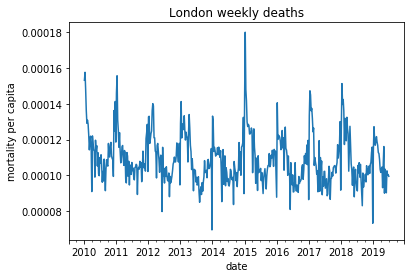

In [175]:
df = linear_df.join(mortality_df).dropna()
df["death_fraction"] = df["weekly_deaths"]/df["total_population"]
df["death_fraction"].plot(legend=False, title="London weekly deaths").set_ylabel("mortality per capita")
plt.show()